<a href="https://colab.research.google.com/github/rubythalib33/Sekolah-AI-Indonesia/blob/main/Course%201.%20Pytorch%2BLightning%20Coureses%20Level%201/1_9_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.9 Autoencoder

## import dependencies

In [1]:
!pip install pytorch_lightning

     |████████████████████████████████| 527 kB 5.3 MB/s 
     |████████████████████████████████| 397 kB 44.8 MB/s 
     |████████████████████████████████| 952 kB 37.3 MB/s 
     |████████████████████████████████| 829 kB 35.9 MB/s 
     |████████████████████████████████| 596 kB 31.8 MB/s 
     |████████████████████████████████| 134 kB 48.5 MB/s 
     |████████████████████████████████| 1.1 MB 8.9 MB/s 
     |████████████████████████████████| 144 kB 35.6 MB/s 
     |████████████████████████████████| 94 kB 675 kB/s 
     |████████████████████████████████| 271 kB 42.3 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=1ada6796404bb9a46004728a79769186f3a976ef780759ea3cf6523639e9ca24
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfull

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms.functional as TF

import pytorch_lightning as pl
from IPython import display
from sklearn.metrics import accuracy_score, precision_score, recall_score

## Load Data

In [3]:
#Download Training and test data from pytorch datasets
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [20]:
batch_size = 16

#create dataloaders
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

## Basic AutoEncoder

In [51]:
latent_dim = 64

class AutoEncoder(pl.LightningModule):
  def __init__(self, input_shape,latent_dim):
    super().__init__()
    self.latent_dim = latent_dim
    self.input_shape = input_shape

    self.epoch = 0
    self.test_sample = next(iter(test_dataloader))

    self.encoder = nn.Sequential(
        nn.Conv2d(1, 16, 3, padding=0, stride=2),
        nn.ReLU(inplace=True),
        nn.Conv2d(16, 8, 3, padding=0, stride=2),
        nn.ReLU(inplace=True),
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2),
        nn.ReLU(inplace=True),
        nn.Conv2d(16, 1, kernel_size=3, padding=1),
        nn.Sigmoid()
    )
    self.loss_fn = nn.MSELoss()
  def forward(self, x):
    B,C,H,W = x.size()
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    decoded = TF.resize(decoded, (H,W))

    return decoded
  
  def training_step(self, batch, batch_bn):
    X, _ = batch
    loss = self.loss_fn(self(X), X)

    return loss
  
  def validation_step(self, batch, batch_bn):
    X, _ = batch
    loss = self.loss_fn(self(X), X)

    return loss

  def validation_epoch_end(self, validation_step_outputs):
    display.clear_output(wait=False)
    self.generate_and_save_images(self.epoch, self.test_sample)
    self.epoch+=1
  
  def generate_and_save_images(self, epoch, test_sample):
    preds = self(test_sample[0].cuda())

    for i in range(preds.shape[0]):
      plt.subplot(4, 4, i + 1)
      plt.imshow(preds[i, 0, :, :].cpu(), cmap='gray')
      plt.axis('off')
    
    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
  
  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=1e-4)

In [52]:
model = AutoEncoder((28,28), latent_dim)

In [53]:
trainer = pl.Trainer(
    gpus=1,
    max_epochs=50,
    progress_bar_refresh_rate=1,
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


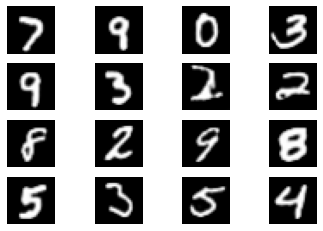

In [ ]:
# Train the model ⚡
trainer.fit(model, train_dataloader, test_dataloader)